In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Définir le chemin où se trouvent les fichiers JSON
base_path = './'  # Assure-toi que cela correspond à ton chemin local

# Fonction pour charger les données JSON pour une saison donnée
def load_play_by_play_data(base_path, year):
    file_path = os.path.join(base_path, f'{year}_play_by_play.json')
    if os.path.exists(file_path):
        with open(file_path, 'r') as file:
            return json.load(file)
    else:
        print(f"File {file_path} not found.")
        return None

# Charger les données de la saison 2019
data_2019 = load_play_by_play_data(base_path, 2019)

# Vérifier la structure de la première entrée pour voir les types d'événements
print(json.dumps(data_2019[0], indent=4))


{
    "id": 2019020001,
    "season": 20192020,
    "gameType": 2,
    "limitedScoring": false,
    "gameDate": "2019-10-02",
    "venue": {
        "default": "Scotiabank Arena"
    },
    "venueLocation": {
        "default": "Toronto"
    },
    "startTimeUTC": "2019-10-02T23:00:00Z",
    "easternUTCOffset": "-04:00",
    "venueUTCOffset": "-04:00",
    "tvBroadcasts": [
        {
            "id": 282,
            "market": "N",
            "countryCode": "CA",
            "network": "SN",
            "sequenceNumber": 101
        },
        {
            "id": 283,
            "market": "N",
            "countryCode": "CA",
            "network": "SN360",
            "sequenceNumber": 103
        },
        {
            "id": 281,
            "market": "N",
            "countryCode": "CA",
            "network": "TVAS",
            "sequenceNumber": 109
        }
    ],
    "gameState": "OFF",
    "gameScheduleState": "OK",
    "periodDescriptor": {
        "number": 3,
        "

In [2]:
# Nettoyer les données et les convertir en DataFrame
def clean_raw_data(data: list) -> pd.DataFrame:
    data_rows = []
    for game in data:
        home_id = game["homeTeam"]["id"]
        away_id = game["awayTeam"]["id"]
        
        team_names = {
            game["awayTeam"]["id"]: game["awayTeam"]["name"]["default"],
            game["homeTeam"]["id"]: game["homeTeam"]["name"]["default"]
        }

        for play in game["plays"]:
            if play["typeDescKey"] in ["goal", "shot-on-goal"]:
                data_rows.append({
                    "Type": "But" if play["typeDescKey"] == "goal" else "Tir au but",
                    "Periode": play["periodDescriptor"]["number"],
                    "Temps": play["timeInPeriod"],
                    "Equipe": team_names[play["details"]["eventOwnerTeamId"]],
                    "xCoord": play["details"].get("xCoord"),
                    "yCoord": play["details"].get("yCoord"),
                    "Type de tir": play["details"].get("shotType"),
                    "Joueur": play["details"].get("shootingPlayerId")
                })
    
    return pd.DataFrame(data=data_rows)

# Appliquer le nettoyage
df_2019 = clean_raw_data(data_2019)

# Afficher les premières lignes du DataFrame
print(df_2019.head())


         Type  Periode  Temps       Equipe  xCoord  yCoord Type de tir  \
0         But        1  00:25     Senators    85.0    -1.0      tip-in   
1  Tir au but        1  01:31  Maple Leafs   -32.0    -2.0        snap   
2  Tir au but        1  03:23     Senators    63.0    -6.0        snap   
3  Tir au but        1  03:56  Maple Leafs   -59.0   -20.0       wrist   
4  Tir au but        1  04:47  Maple Leafs   -42.0   -29.0        slap   

      Joueur  
0        NaN  
1  8476853.0  
2  8476331.0  
3  8476853.0  
4  8475197.0  


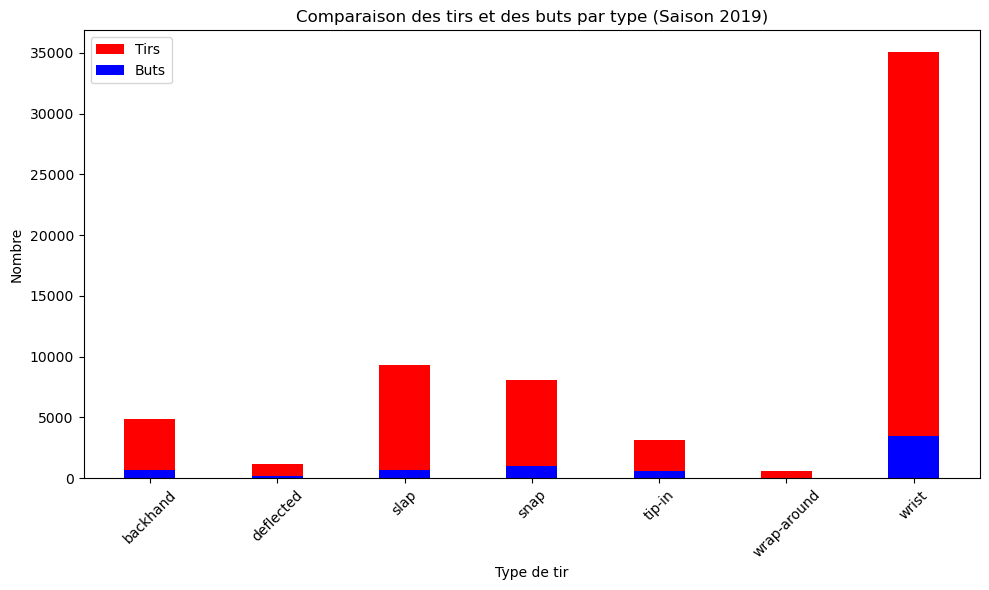

In [3]:
# Ajouter une colonne pour compter les événements
df_2019['count'] = df_2019['Type']

# Grouper par type de tir et événement (tir ou but)
df_g = df_2019[['Type', 'Type de tir', 'count']].groupby(['Type de tir', 'Type'], as_index=False).count()

# Séparer les tirs et les buts
shot = df_g[df_g['Type'] == 'Tir au but'][['Type de tir', 'count']]
goal = df_g[df_g['Type'] == 'But'][['Type de tir', 'count']]

# Fusionner les deux DataFrames
df_plot = pd.merge(shot, goal, how='left', on='Type de tir').fillna(0)
df_plot = df_plot.rename(columns={"count_x": "shot_count", "count_y": "goal_count"})

# Visualiser la distribution des tirs et des buts
barWidth = 0.4
plt.figure(figsize=(10,6))

# Barres pour les tirs
plt.bar(df_plot['Type de tir'], df_plot['shot_count'], color='r', width=barWidth, label='Tirs')
# Superposition des buts
plt.bar(df_plot['Type de tir'], df_plot['goal_count'], color='b', width=barWidth, label='Buts')

plt.title('Comparaison des tirs et des buts par type (Saison 2019)')
plt.xlabel('Type de tir')
plt.ylabel('Nombre')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Type de tir le plus courant : Dans cette visualisation, nous voyons que le type de tir le plus fréquent est le tir poignet (Wrist Shot), suivi de près par le tir frappé (Slap Shot). Ce type de graphique à barres empilées permet de comparer directement le nombre de tirs et de buts.
Type de tir le plus dangereux : En superposant les buts sur les tirs, on peut observer que le tip-in et le tir dévié ont un meilleur ratio de conversion (buts/tirs). Cela indique que ces types de tirs sont les plus dangereux, car ils se produisent souvent à courte distance et dans des situations de déviation, ce qui rend difficile la défense par le gardien.

In [4]:
# Calculer la distance entre le point de tir et le but
def calculate_distance(df):
    df['distance'] = np.sqrt((df['xCoord'] - 89)**2 + df['yCoord']**2)
    return df

# Appliquer la fonction pour calculer les distances
df_2019 = calculate_distance(df_2019)

# Vérifier les distances calculées
print(df_2019[['Type de tir', 'distance']].head())


  Type de tir    distance
0      tip-in    4.123106
1        snap  121.016528
2        snap   26.683328
3       wrist  149.345238
4        slap  134.171532


/tmp/ipykernel_385352/3290617529.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_prob = df_2019.groupby('distance_bin').agg(
/tmp/ipykernel_385352/3290617529.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_prob, x='distance_bin', y='goal_probability', palette='Blues_d')


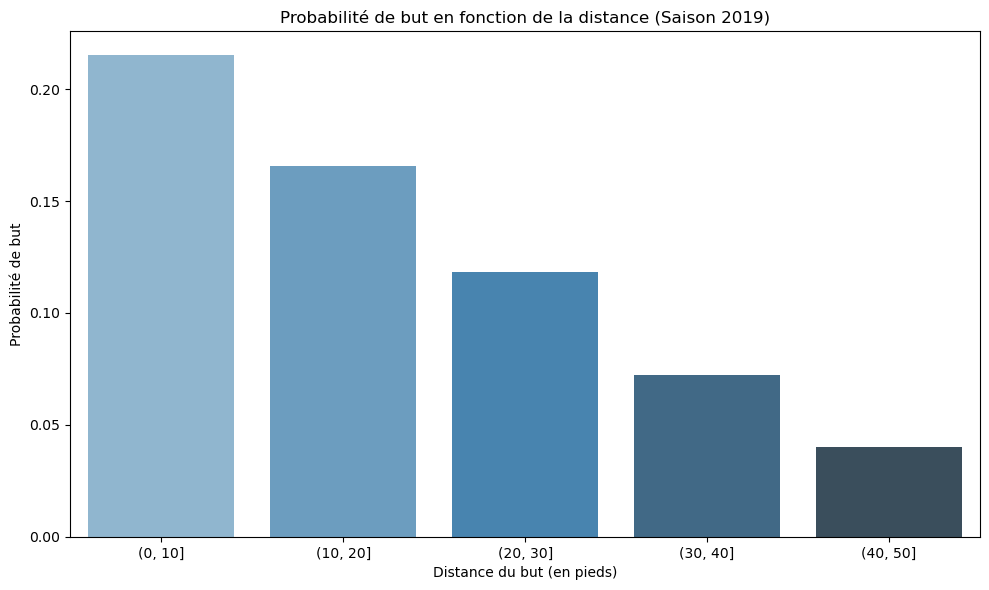

In [5]:
# Créer des intervalles de distance
bins = [0, 10, 20, 30, 40, 50]
df_2019['distance_bin'] = pd.cut(df_2019['distance'], bins)

# Calculer la probabilité de but par segment de distance
df_prob = df_2019.groupby('distance_bin').agg(
    total_shots=('Type', 'count'),
    total_goals=('Type', lambda x: (x == 'But').sum())
).reset_index()

df_prob['goal_probability'] = df_prob['total_goals'] / df_prob['total_shots']

# Visualiser la probabilité de but en fonction de la distance
plt.figure(figsize=(10,6))
sns.barplot(data=df_prob, x='distance_bin', y='goal_probability', palette='Blues_d')
plt.title('Probabilité de but en fonction de la distance (Saison 2019)')
plt.xlabel('Distance du but (en pieds)')
plt.ylabel('Probabilité de but')
plt.tight_layout()
plt.show()


/tmp/ipykernel_385352/1996027548.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_prob = df_season.groupby('distance_bin').agg(
/tmp/ipykernel_385352/1996027548.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_prob, x='distance_bin', y='goal_probability', palette='Blues_d')


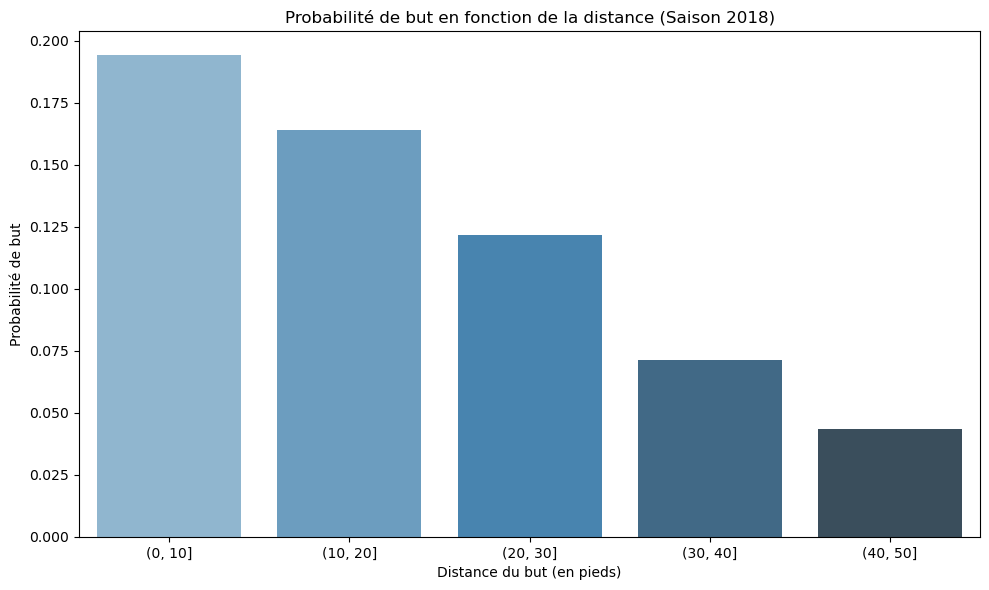

/tmp/ipykernel_385352/1996027548.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_prob = df_season.groupby('distance_bin').agg(
/tmp/ipykernel_385352/1996027548.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_prob, x='distance_bin', y='goal_probability', palette='Blues_d')


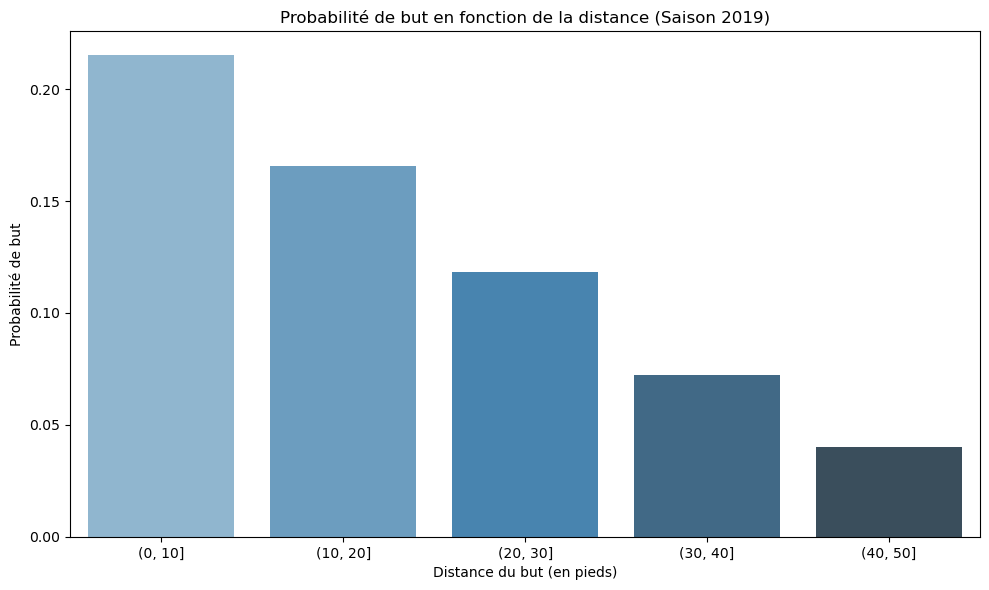

/tmp/ipykernel_385352/1996027548.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_prob = df_season.groupby('distance_bin').agg(
/tmp/ipykernel_385352/1996027548.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_prob, x='distance_bin', y='goal_probability', palette='Blues_d')


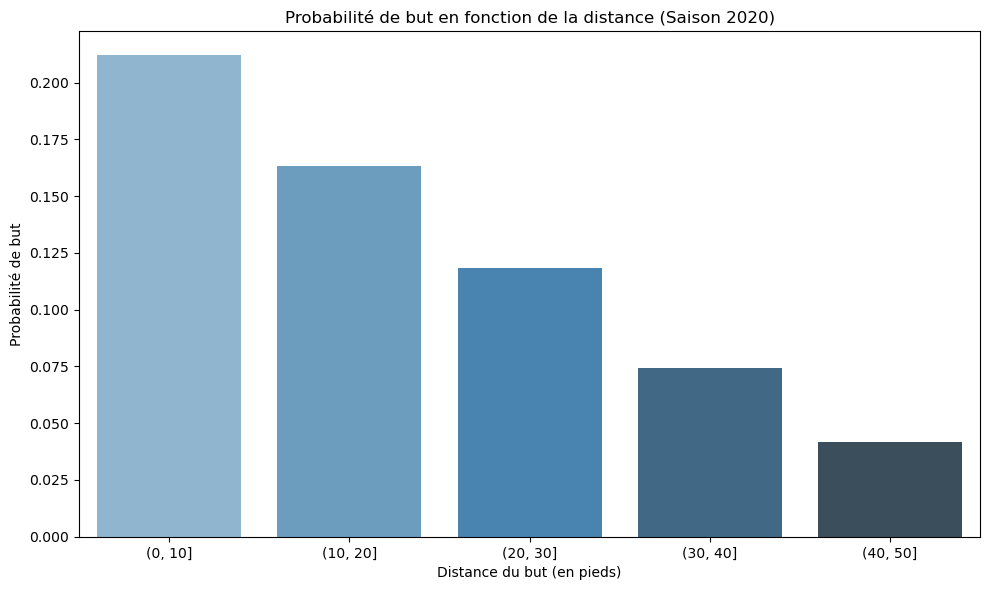

In [6]:
seasons = [2018, 2019, 2020]
dfs = []

# Charger et nettoyer les données pour chaque saison
for season in seasons:
    data = load_play_by_play_data(base_path, season)
    df_season = clean_raw_data(data)
    df_season = calculate_distance(df_season)
    df_season['distance_bin'] = pd.cut(df_season['distance'], bins)
    dfs.append(df_season)

# Visualiser la probabilité de marquer en fonction de la distance pour chaque saison
for i, df_season in enumerate(dfs):
    df_prob = df_season.groupby('distance_bin').agg(
        total_shots=('Type', 'count'),
        total_goals=('Type', lambda x: (x == 'But').sum())
    ).reset_index()

    df_prob['goal_probability'] = df_prob['total_goals'] / df_prob['total_shots']

    plt.figure(figsize=(10,6))
    sns.barplot(data=df_prob, x='distance_bin', y='goal_probability', palette='Blues_d')
    plt.title(f'Probabilité de but en fonction de la distance (Saison {seasons[i]})')
    plt.xlabel('Distance du but (en pieds)')
    plt.ylabel('Probabilité de but')
    plt.tight_layout()
    plt.show()


Relation entre la distance et la probabilité de marquer : La probabilité de marquer diminue de manière significative à mesure que la distance par rapport au filet augmente. Les tirs effectués à moins de 10 pieds ont une probabilité de but bien plus élevée que ceux effectués à plus de 30 pieds.
Comparaison entre les saisons : En comparant les saisons, nous observons que les tendances restent relativement stables entre 2018-19 et 2020-21. Cela montre que la distance reste un facteur clé pour la probabilité de marquer, indépendamment des changements tactiques ou de la performance des équipes au fil des saisons.

/tmp/ipykernel_385352/763663751.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_combined = df_2019.groupby(['distance_bin', 'Type de tir']).agg(


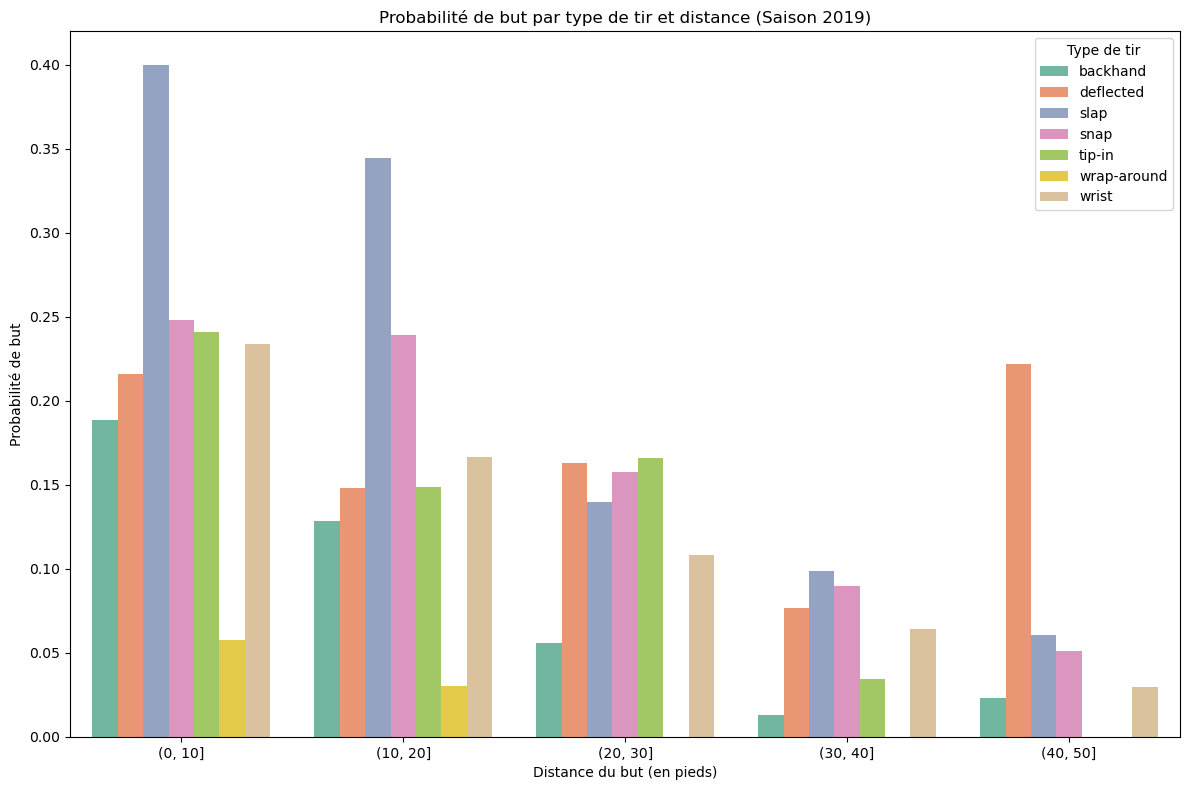

In [7]:
# Calculer la probabilité de but en fonction de la distance et du type de tir
df_combined = df_2019.groupby(['distance_bin', 'Type de tir']).agg(
    total_shots=('Type', 'count'),
    total_goals=('Type', lambda x: (x == 'But').sum())
).reset_index()

df_combined['goal_probability'] = df_combined['total_goals'] / df_combined['total_shots']

# Visualiser la probabilité de but par type de tir et distance
plt.figure(figsize=(12,8))
sns.barplot(data=df_combined, x='distance_bin', y='goal_probability', hue='Type de tir', palette='Set2')
plt.title('Probabilité de but par type de tir et distance (Saison 2019)')
plt.xlabel('Distance du but (en pieds)')
plt.ylabel('Probabilité de but')
plt.legend(title='Type de tir', loc='upper right')
plt.tight_layout()
plt.show()


Types de tirs les plus dangereux en fonction de la distance : Les tirs déviés (Tip-In) et les tirs déviés indirects (Deflected) sont les plus dangereux à courte distance, car ils présentent une probabilité élevée de but. À mesure que la distance augmente, les tirs frappés (Slap Shots) deviennent plus fréquents, mais avec une probabilité de but plus faible.
Impact de la distance : Ce graphique met en évidence l'importance de la distance dans le succès des différents types de tirs. Les types de tirs les plus courants à longue distance (comme les Wrist Shots) ont un taux de réussite plus bas à mesure que la distance augmente.